In [1]:
import cv2, numpy as np
import math
import time
import random
from matplotlib import pyplot as plt
%matplotlib inline


def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [6]:
orb = cv2.ORB_create()

matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)


images = ['./book/book1.jpg', './book/book2.jpg', './book/book3.jpg', './book/book4.jpg', ] 

database_kp = []
database_desc = []
for name in images :
    img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    keypoints, desc = orb.detectAndCompute(img, None)
    database_kp.append(keypoints)
    database_desc.append(desc)

47.82
32.44
52.46
40.8


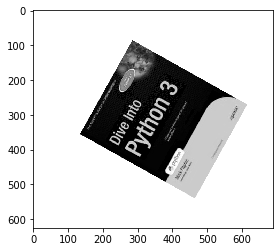

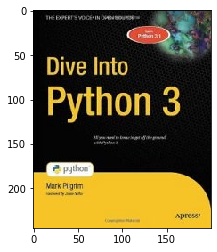

In [9]:
test = cv2.imread("./book/book.png", cv2.IMREAD_GRAYSCALE)
keypoints, desc = orb.detectAndCompute(test, None)


min_distance = 1000
idx = -1
for i in range(len(images)):
    matches = matcher.match(desc, database_desc[i])
    matches = sorted(matches, key=lambda x: x.distance)
    good_matches = matches[:50]

    distance = 0
    for d in good_matches:
        distance += d.distance
    distance /= len(good_matches)
    print(distance)

    if min_distance > distance:
        min_distance = distance
        idx = i

imshow("", test)
imshow("", cv2.imread(images[idx]))

In [31]:
src1 = cv2.imread('./book/box.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('./book/box_in_scene.png', cv2.IMREAD_GRAYSCALE)
    
keypoints1, desc1 = orb.detectAndCompute(src1, None)
keypoints2, desc2 = orb.detectAndCompute(src2, None)

matches = matcher.match(desc1, desc2)
matches = sorted(matches, key=lambda x : x.distance)
good_matches = matches[:50]

In [32]:
pts1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)
pts2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)


print(pts1.shape)
print(pts2.shape) # 50,1,2

(50, 1, 2)
(50, 1, 2)


In [33]:
H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC) #평면이 어떻게 옮겨졌는지를 계산, 회전정보와 이동정보
print(H)

[[ 4.85610150e-01 -1.26423343e-01  1.16639863e+02]
 [ 3.62734153e-02  4.76039278e-01  1.58710108e+02]
 [-1.20390936e-04 -1.08741047e-04  1.00000000e+00]]


In [38]:
(h, w) = src1.shape[:2]
corners1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2).astype(np.float32)
corners2 = cv2.perspectiveTransform(corners1, H)

print(corners1)
print(corners2)

[[[  0.   0.]]

 [[  0. 222.]]

 [[323. 222.]]

 [[323.   0.]]]
[[[116.63986 158.71011]]

 [[ 90.76499 270.93124]]

 [[261.93488 294.67987]]

 [[284.5573  177.32181]]]


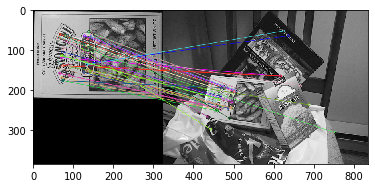

In [35]:
dst = cv2.drawMatches(src1, keypoints1, src2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow('', dst)

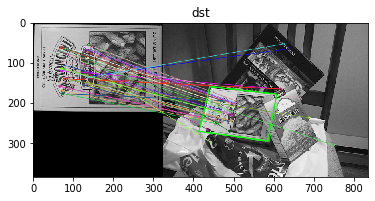

In [36]:
corners3 = corners2 + np.float32([w, 0]) 

cv2.polylines(dst, [np.int32(corners3)], True, (0, 255, 0), 2, cv2.LINE_AA)
imshow('dst', dst) #pointer의 관계를 알고 있을 경우 두 이미지간 기하학적 관계 파악 가능, 두개의 이미지에서 공통된 특징점을 찾아 매칭

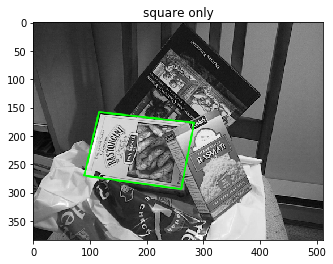

In [41]:
test = cv2.imread('./book/box_in_scene.png')
cv2.polylines(test, [np.int32(corners2)], True, (0, 255, 0), 2, cv2.LINE_AA)
imshow('square only', test)

## practice

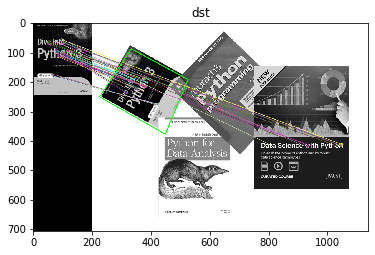

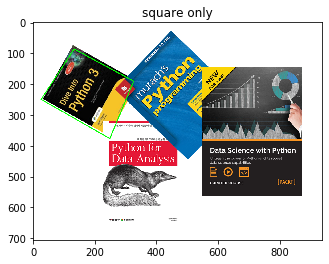

In [56]:
src1 = cv2.imread('./book/book2.jpg', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('./book/test_books.png', cv2.IMREAD_GRAYSCALE)

keypoints1, desc1 = orb.detectAndCompute(src1, None)
keypoints2, desc2 = orb.detectAndCompute(src2, None)

matches = matcher.match(desc1, desc2)
matches = sorted(matches, key=lambda x: x.distance)
good_matches = matches[:50]

pts1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches]
                ).reshape(-1, 1, 2).astype(np.float32)
pts2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches]
                ).reshape(-1, 1, 2).astype(np.float32)

H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC)

(h, w) = src1.shape[:2]
corners1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]
                    ).reshape(-1, 1, 2).astype(np.float32)
corners2 = cv2.perspectiveTransform(corners1, H)

dst = cv2.drawMatches(src1, keypoints1, src2, keypoints2, good_matches,
                      None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

corners3 = corners2 + np.float32([w, 0])

cv2.polylines(dst, [np.int32(corners3)], True, (0, 255, 0), 2, cv2.LINE_AA)
imshow('dst', dst)

test = cv2.imread('./book/test_books.png')
cv2.polylines(test, [np.int32(corners2)], True, (0, 255, 0), 2, cv2.LINE_AA)
imshow('square only', test)

## 함수화

In [74]:
def find_target(target, place):
    place_origin = place
    target_img = cv2.imread(target, cv2.IMREAD_GRAYSCALE)
    place_img = cv2.imread(place, cv2.IMREAD_GRAYSCALE)

    keypoints1, desc1 = orb.detectAndCompute(target_img, None)
    keypoints2, desc2 = orb.detectAndCompute(place_img, None)

    matches = matcher.match(desc1, desc2)
    matches = sorted(matches, key=lambda x: x.distance)
    good_matches = matches[:50]

    pts1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches]
                    ).reshape(-1, 1, 2).astype(np.float32)
    pts2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches]
                    ).reshape(-1, 1, 2).astype(np.float32)

    H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC)

    (h, w) = target_img.shape[:2]
    corners1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]
                        ).reshape(-1, 1, 2).astype(np.float32)
    corners2 = cv2.perspectiveTransform(corners1, H)

    dst = cv2.drawMatches(target_img, keypoints1, place_img, keypoints2,
                          good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    corners3 = corners2 + np.float32([w, 0])

    cv2.polylines(dst, [np.int32(corners3)], True, (0, 255, 0), 2, cv2.LINE_AA)
    imshow('target process', dst)

    test = cv2.imread(place_origin)
    cv2.polylines(test, [np.int32(corners2)], True,
                  (0, 255, 0), 5, cv2.LINE_AA)
    imshow('square only', test)

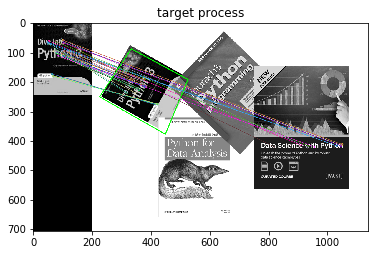

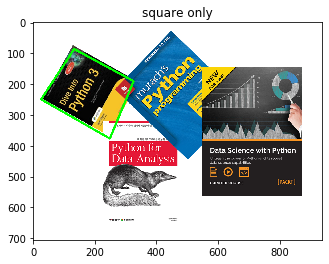

In [75]:
src1 = './book/book2.jpg'
src2 = './book/test_books.png'

find_target(src1, src2)